In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

df  = pd.read_csv("../ETL/iot_agriculture_clean.csv")
df["date"] = pd.to_datetime(df["date"], errors='coerce')



In [15]:
# ===== TARGET =====
target = "Watering_plant_pump_ON"


In [16]:

# ===== Columnas a eliminar =====
cols_leakage = [
    "Watering_plant_pump_OFF",
    "Water_pump_actuator_ON",
    "Water_pump_actuator_OFF",
    "Fan_actuator_ON",
    "Fan_actuator_OFF"
]

dummy_drop = ["DOW_0"]  # evitar multicolinealidad

# ===== Separar X & y =====
y = df[target]
X = df.drop(columns=cols_leakage + dummy_drop + [target, 'date'], errors='ignore')

# ===== Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
# ===== SelectKBest =====
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]
print("\n✅ Top 10 Features por SelectKBest:")
print(list(selected_features))

# ===== Filtrar datasets con solo top features =====
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]


✅ Top 10 Features por SelectKBest:
['humidity', 'N', 'P', 'K', 'NPK_index', 'month', 'is_weekend', 'DOW_1', 'DOW_3', 'DOW_4']


# Logistic Regression vs Random Forest

Comparamos modelos clasificadores y ver cuál toma mejor la decisión ON/OFF de riego.


## MODELO: Logistic Regression

In [18]:
# === Entrenar Logistic Regression ===
logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train_sel, y_train)


# === Predicciones === 
y_pred_log = logistic_model.predict(X_test_sel)

print("\n📊 Logistic Regression Results (SelectKBest features):")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))


📊 Logistic Regression Results (SelectKBest features):
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      5824
         1.0       0.98      0.86      0.91      1760

    accuracy                           0.96      7584
   macro avg       0.97      0.93      0.95      7584
weighted avg       0.96      0.96      0.96      7584

Accuracy: 0.9628164556962026


## MODELO: RandomForest


In [19]:
# ===== Entrenar Random Forest =====
randomForest_model = RandomForestClassifier(random_state=42, n_estimators=200)
randomForest_model.fit(X_train_sel, y_train)

# === Predicciones ===
y_pred_rf = randomForest_model.predict(X_test_sel)

print("\n📊 Random Forest Results (SelectKBest features):")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


📊 Random Forest Results (SelectKBest features):
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5824
         1.0       0.98      0.97      0.98      1760

    accuracy                           0.99      7584
   macro avg       0.99      0.98      0.99      7584
weighted avg       0.99      0.99      0.99      7584

Accuracy: 0.9901107594936709


# Modelo LinearRegression 
Predicción de humedad futura

In [20]:
# -------------------------------
# 1️ Preparación: Target futuro
# -------------------------------

# === TARGET FUTURO === 
df['humidity_future'] = df['humidity'].shift(-1)
df_reg = df.dropna()  # eliminar última fila que queda NaN

In [21]:
# Features para regresión
features_regressionLinear = ['humidity', 'tempreature', 'N', 'P', 'K', 'NPK_index', 'hour', 'is_weekend']
X_regressionLinear = df_reg[features_regressionLinear]
y_regressionLinear = df_reg['humidity_future']

# Train/Test split
X_train_regressionLinear, X_test_regressionLinear, y_train_regressionLinear, y_test_regressionLinear = train_test_split(
    X_regressionLinear, y_regressionLinear, test_size=0.2, random_state=42
)

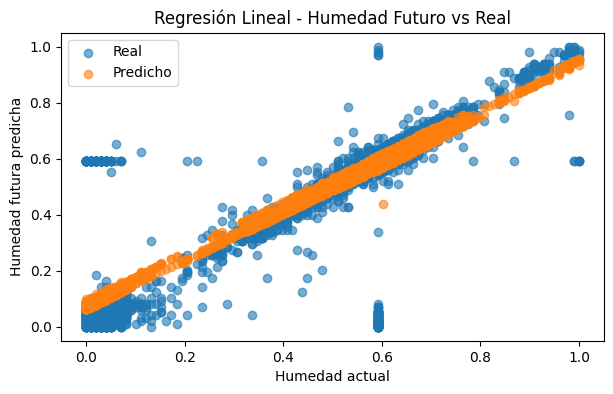

MAE: 0.043091274770514644
RMSE: 0.10204239788490835


In [22]:
from sklearn.metrics import mean_squared_error

# === Modelo de regresión lineal  === 
linearRegression_model = LinearRegression()
linearRegression_model.fit(X_train_regressionLinear, y_train_regressionLinear)

# Predicciones
y_predict_regressionLinear = linearRegression_model.predict(X_test_regressionLinear)

plt.figure(figsize=(7,4))

# Graficamos usando humedad como eje X
plt.scatter(X_test_regressionLinear['humidity'], y_test_regressionLinear, label="Real", alpha=0.6)
plt.scatter(X_test_regressionLinear['humidity'], y_predict_regressionLinear, label="Predicho", alpha=0.6)

plt.xlabel("Humedad actual")
plt.ylabel("Humedad futura predicha")
plt.title("Regresión Lineal - Humedad Futuro vs Real")
plt.legend()
plt.show()

# Métricas
print("MAE:", mean_absolute_error(y_test_regressionLinear, y_predict_regressionLinear))
print("RMSE:", sqrt(mean_squared_error(y_test_regressionLinear, y_predict_regressionLinear)))


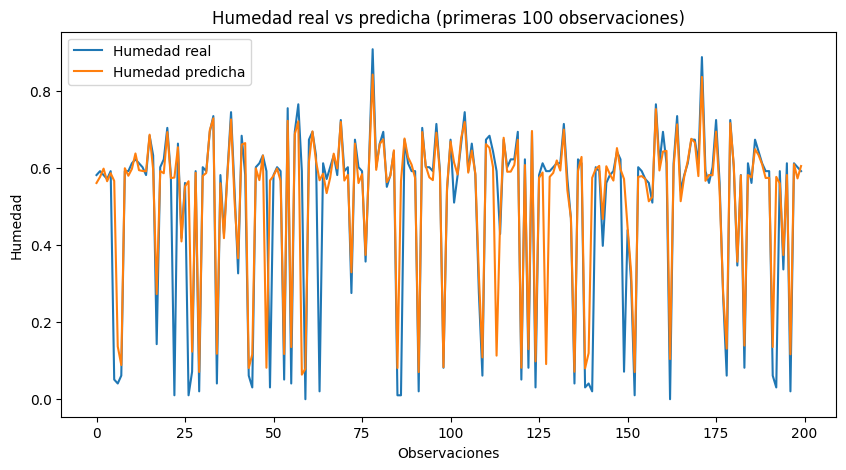

In [23]:
# Graficar comparación
plt.figure(figsize=(10,5))
plt.plot(y_test_regressionLinear.values[:200], label='Humedad real')
plt.plot(y_predict_regressionLinear[:200], label='Humedad predicha')
plt.title("Humedad real vs predicha (primeras 100 observaciones)")
plt.xlabel("Observaciones")
plt.ylabel("Humedad")
plt.legend()
plt.show()

# SISTEMA DE RIEGO INTELIGENTE IOT


In [24]:
# -------------------------------
# 1️ Preparación: Target futuro
# -------------------------------
humedad_futura = "humidity_future"
df[humedad_futura] = df['humidity'].shift(-1)
df_reg = df.dropna()  # eliminar última fila con NaN

# Features para regresión
features_regressionLinear = ['humidity', 'tempreature', 'N', 'P', 'K', 'NPK_index', 'hour', 'is_weekend']
X_regressionLinear = df_reg[features_regressionLinear]
y_regressionLinear = df_reg[humedad_futura]

# Train/Test split
X_train_regressionLinear, X_test_regressionLinear, y_train_regressionLinear, y_test_regressionLinear = train_test_split(
    X_regressionLinear, y_regressionLinear, test_size=0.2, random_state=42
    )


In [25]:
# -------------------------------
# 2️ Modelo de regresión
# -------------------------------
linearRegression_model = LinearRegression()
linearRegression_model.fit(X_train_regressionLinear, y_train_regressionLinear)
y_predict_regressionLinear = linearRegression_model.predict(X_test_regressionLinear)

print("MAE:", mean_absolute_error(y_test_regressionLinear, y_predict_regressionLinear))
print("RMSE:", sqrt(mean_squared_error(y_test_regressionLinear, y_predict_regressionLinear)))




MAE: 0.043091274770514644
RMSE: 0.10204239788490835


In [26]:

# -------------------------------
# 3️ Simulación de humedad variada (para tener casos 0 y 1)
# -------------------------------
df_iot = X_test_regressionLinear.copy()
df_iot['hour'] = X_test_regressionLinear['hour'].values

np.random.seed(42)
df_iot['predicted_humidity'] = y_predict_regressionLinear + np.random.normal(0, 0.1, size=len(y_predict_regressionLinear))
df_iot['predicted_humidity'] = df_iot['predicted_humidity'].clip(0,1)
df_iot['humidity'] = X_test_regressionLinear['humidity']  # Humedad real

In [27]:
df_iot.shape

(7584, 9)

##  Primer regla:

    SI HUMEDAD PREDICHA < 30% --> ENCENDER BOMBA

In [28]:

# -------------------------------
# 4️ Regla simple 
# -------------------------------
regla_de_riego ="watering_rule"
prediccion_humedad ='predicted_humidity'

df_iot[regla_de_riego] = (df_iot[prediccion_humedad] < 0.3).astype(int)


In [29]:
df_iot[regla_de_riego]

25874    0
33381    0
33445    0
28814    0
29627    0
        ..
8238     1
2104     0
2292     0
10476    0
29022    0
Name: watering_rule, Length: 7584, dtype: int64

In [ ]:
# -------------------------------
# 5️ Clasificador inteligente
# -------------------------------

# Features del clasificador 

features_clf = ['humidity', 'N', 'P', 'K', 'NPK_index', 'is_weekend'] 
clf = RandomForestClassifier(random_state=42, n_estimators=200)

# Creamos target inteligente para entrenamiento
df['target_water_future'] = (df['humidity_future'] < 0.3).astype(int)

X_clf = df[features_clf]
y_clf = df['target_water_future']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

clf.fit(X_train_clf, y_train_clf)

# Predicción con clasificador
df_iot['watering_clf'] = clf.predict(df_iot[features_clf])


In [31]:
# -------------------------------
# 6️ Realidad simulada
# -------------------------------
df_iot['watering_real'] = (df_iot['humidity'] < 0.3).astype(int)

In [32]:
# Evaluar contra realidad
y_true_rule = (y_test_regressionLinear < 30).astype(int)
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_rule = accuracy_score(y_true_rule, df_iot['watering_rule'])
cm_rule = confusion_matrix(y_true_rule, df_iot['watering_rule'], labels=[0,1])


print("✅ Accuracy regla simple:", accuracy_rule)
print("Matriz de Confusión regla simple:\n", cm_rule)

✅ Accuracy regla simple: 0.1559862869198312
Matriz de Confusión regla simple:
 [[   0    0]
 [6401 1183]]


In [33]:
# Crear predicciones del clasificador (para test)
y_pred_clf = clf.predict(X_test_clf)

In [34]:
# Evaluación del clasificador
from sklearn.metrics import classification_report
print("\n📊 Clasificador inteligente de riego")
print(classification_report(y_test_clf, y_pred_clf))

cm_clf = confusion_matrix(y_test_clf, y_pred_clf, labels=[0,1])
print("Matriz de Confusión clasificador:\n", cm_clf)



📊 Clasificador inteligente de riego
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6446
           1       0.91      0.88      0.89      1138

    accuracy                           0.97      7584
   macro avg       0.94      0.93      0.94      7584
weighted avg       0.97      0.97      0.97      7584

Matriz de Confusión clasificador:
 [[6341  105]
 [ 136 1002]]


In [35]:
# =========================================
# 4️ IMPLEMENTACIÓN REAL (IoT)
# =========================================

# Ejemplo pseudo-código de control predictivo
# humidity_actual = leer_sensor_humedad()
# features_actuales = [humidity_actual, temp, N,P,K, NPK_index, hour, is_weekend, ...]
# predicted_humidity = lr_model.predict([features_actuales])[0]

# Regla simple:
# if predicted_humidity < 40:
#     encender_bomba()
# else:
#     apagar_bomba()

# Clasificador inteligente:
# decision_bomba = clf_final.predict([features_actuales])[0]
# if decision_bomba == 1:
#     encender_bomba()
# else:
#     apagar_bomba()

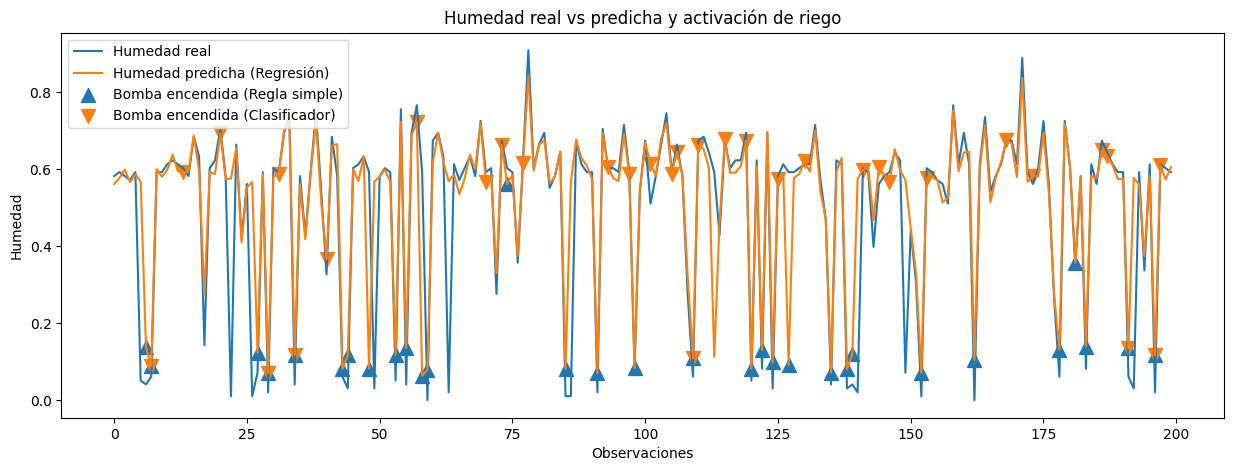

In [36]:

# Tomamos las primeras 200 observaciones para que se vea claro
n_obs = 200

y_real = y_test_regressionLinear.values[:n_obs]
y_pred = y_predict_regressionLinear[:n_obs]

# Reglas de riego simuladas (del df_iot)
watering_rule = df_iot['watering_rule'].values[:n_obs]

# Clasificador inteligente
X_test_clf_plot = X_test_clf.iloc[:n_obs]
y_pred_clf_plot = clf.predict(X_test_clf_plot)  # usamos clf, no clf_final

plt.figure(figsize=(15,5))

# Humedad real y predicha
plt.plot(y_real, label='Humedad real')
plt.plot(y_pred, label='Humedad predicha (Regresión)')

# Marcamos los momentos donde se activa la bomba por regla simple
plt.scatter(np.arange(n_obs)[watering_rule==1], 
            y_pred[watering_rule==1], 
            marker='^', s=100, label='Bomba encendida (Regla simple)')

# Marcamos los momentos donde se activa la bomba por clasificador inteligente
plt.scatter(np.arange(n_obs)[y_pred_clf_plot==1], 
            y_pred[y_pred_clf_plot==1], 
            marker='v', s=100, label='Bomba encendida (Clasificador)')

plt.title("Humedad real vs predicha y activación de riego")
plt.xlabel("Observaciones")
plt.ylabel("Humedad")
plt.legend()
plt.show()


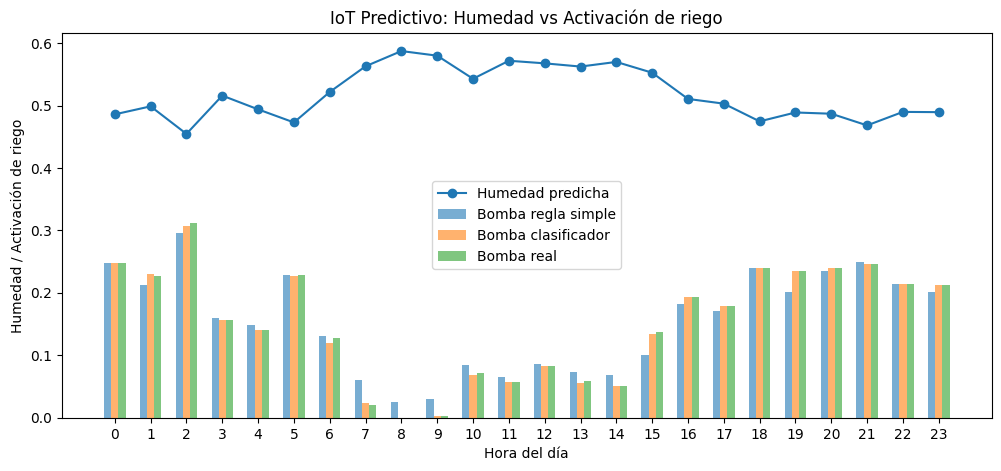

📊 Regla simple vs realidad
[[6326   90]
 [  75 1093]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6416
           1       0.92      0.94      0.93      1168

    accuracy                           0.98      7584
   macro avg       0.96      0.96      0.96      7584
weighted avg       0.98      0.98      0.98      7584

📊 Clasificador vs realidad
[[6412    4]
 [  12 1156]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6416
           1       1.00      0.99      0.99      1168

    accuracy                           1.00      7584
   macro avg       1.00      0.99      1.00      7584
weighted avg       1.00      1.00      1.00      7584


Primeras 10 filas de comparación:
       hour  humidity  predicted_humidity  watering_rule  watering_clf  \
25874    20  0.581633            0.610707              0             0   
33381     3  0.602041            0.563034              

In [37]:
# -------------------------------
# 7️⃣ Gráfica por hora
# -------------------------------
hourly_iot = df_iot.groupby('hour').agg({
    'predicted_humidity':'mean',
    'watering_rule':'mean',
    'watering_clf':'mean',
    'watering_real':'mean'
}).reset_index()

plt.figure(figsize=(12,5))
plt.plot(hourly_iot['hour'], hourly_iot['predicted_humidity'], marker='o', label='Humedad predicha')
plt.bar(hourly_iot['hour']-0.2, hourly_iot['watering_rule'], width=0.2, alpha=0.6, label='Bomba regla simple')
plt.bar(hourly_iot['hour'], hourly_iot['watering_clf'], width=0.2, alpha=0.6, label='Bomba clasificador')
plt.bar(hourly_iot['hour']+0.2, hourly_iot['watering_real'], width=0.2, alpha=0.6, label='Bomba real')
plt.title("IoT Predictivo: Humedad vs Activación de riego")
plt.xlabel("Hora del día")
plt.ylabel("Humedad / Activación de riego")
plt.xticks(range(0,24))
plt.legend()
plt.show()

# -------------------------------
# 8️⃣ Matrices de confusión
# -------------------------------
from sklearn.metrics import confusion_matrix, classification_report

print("📊 Regla simple vs realidad")
print(confusion_matrix(df_iot['watering_real'], df_iot['watering_rule']))
print(classification_report(df_iot['watering_real'], df_iot['watering_rule']))

print("📊 Clasificador vs realidad")
print(confusion_matrix(df_iot['watering_real'], df_iot['watering_clf']))
print(classification_report(df_iot['watering_real'], df_iot['watering_clf']))

# -------------------------------
# 9️⃣ Tabla de comparación
# -------------------------------
print("\nPrimeras 10 filas de comparación:")
print(df_iot[['hour','humidity','predicted_humidity','watering_rule','watering_clf','watering_real']].head(10))
